In [25]:
import glob
import math
import os
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from control.matlab import *

#### グラフをプロットするときの線種を決めるジェネレータ

In [26]:
def linestyle_generator():
    linestyle = ['-', '--', '-', ':']
    lineID = 0
    while True:
        yield linestyle[lineID]
        lineID = (lineID + 1) % len(linestyle)

#### グラフを整える関数

In [27]:
def plot_set(fig_ax, *args):
    fig_ax.set_xlabel(args[0])  # x軸のラベルを1つめの引数で設定
    fig_ax.set_ylabel(args[1])  # y軸のラベルを2つめの引数で設定
    fig_ax.grid(ls=':')
    if len(args) == 3:
        fig_ax.legend(loc=args[2]) # 凡例の位置を3つめの引数で設定

#### ボード線図を整える関数

In [28]:
def bodeplot_set(fig_ax, *args):
    #  ゲイン線図のグリッドとy軸ラベルの設定
    fig_ax[0].grid(which='both', ls=':')
    fig_ax[0].set_ylabel('Gain [dB]') # 本文中の図では「ゲイン[dB]」と表示
    #  位相線図のグリッドとx軸、y軸ラベルの設定
    fig_ax[1].grid(which='both', ls=':')
    fig_ax[1].set_xlabel('$\omega$ [rad/s]')
    fig_ax[1].set_ylabel('Phase [deg]') # 本文中の図では「位相[deg]」と表示
    #  凡例の表示
    if len(args) > 0:
        fig_ax[1].legend(loc=args[0]) # 引数が1つ以上：ゲイン線図に表示
    if len(args) > 1:
        fig_ax[0].legend(loc=args[1]) # 引数が2つ以上：位相線図に表示

# 1次遅れ系のステップ応答

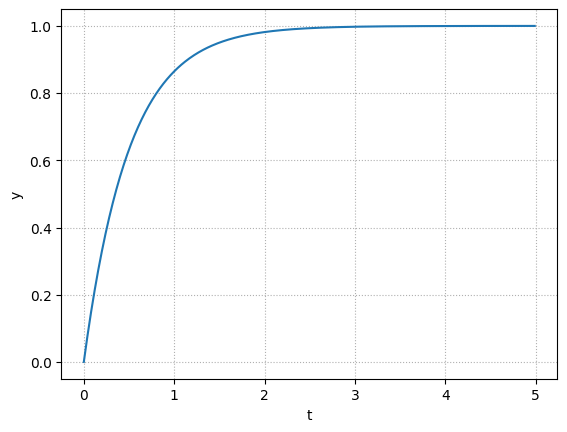

In [29]:
T, K = 0.5, 1 # 時定数とゲインの設定
P = tf([0, K], [T, 1]) # 1次遅れ系
y, t = step(P, np.arange(0, 5, 0.01)) # ステップ応答

fig, ax = plt.subplots()
ax.plot(t, y)
plot_set(ax, 't', 'y')

# 第5章　PID制御 

垂直駆動アームモデル

In [30]:
g = 9.81        # 重力加速度[m/s^2]
l = 0.2         # アームの長さ[m]
M = 0.5         # アームの質量[kg]
mu = 1.5e-2     # 粘性摩擦係数[kg*m^2/s]
J = 1.0e-2      # 慣性モーメント[kg*m^2]

P = tf([0, 1], [J, mu, M*g*l])      # 伝達関数モデル

ref = 30        # 目標角度[deg]

P制御を用いたときのステップ応答

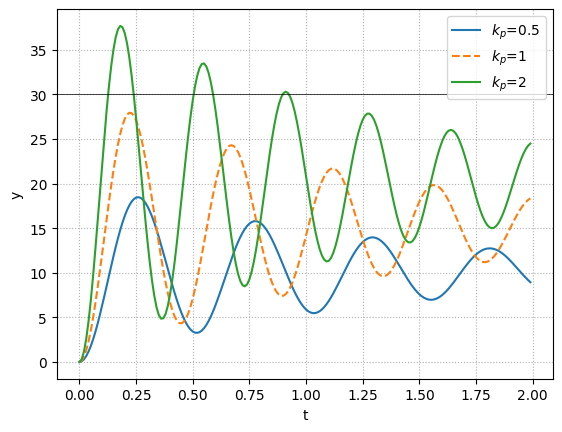

In [31]:
kp = (0.5, 1, 2)

LS = linestyle_generator()
fig, ax = plt.subplots()
for i in range(3):
    K = tf([0, kp[i]], [0, 1])  # P制御
    Gyr = feedback(P * K, 1)    # 閉ループ系
    y, t = step(Gyr, np.arange(0, 2, 0.01)) # ステップ応答

    pltargs = {'ls' : next(LS), 'label' : '$k_p$=' + str(kp[i])}
    ax.plot(t, y*ref, **pltargs)

ax.axhline(ref, color='k', linewidth=0.5)
plot_set(ax, 't', 'y', 'best')

* 比例ゲインが大きくすると、立ち上がりが速くなり、振動の周期も短くなる。

P制御を用いたときのボード線図

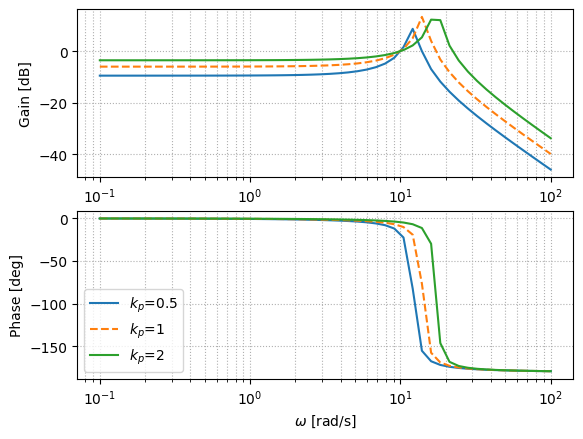

In [32]:
LS = linestyle_generator()
fig, ax = plt.subplots(2, 1)

for i in range(len(kp)):
    K = tf([0, kp[i]], [0, 1])      # P制御
    Gyr = feedback(P*K, 1)          # 閉ループ系

    # bode diagram
    gain, phase, w = bode(Gyr, logspace(-1, 2), plot=False)

    pltargs = {'ls': next(LS), 'label': '$k_p$=' + str(kp[i])}
    ax[0].semilogx(w, 20 * np.log10(gain), **pltargs)
    ax[1].semilogx(w, phase*180/np.pi, **pltargs)
bodeplot_set(ax, 'lower left')

* 比例ゲインが大きくなると、低周波ゲインが大きくなり、バンド幅とピークゲインが大きくなる

### PD制御を用いたときのステップ応答

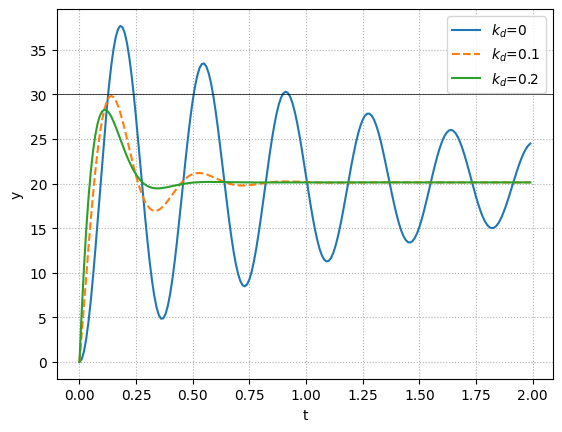

In [33]:
kp = 2
kd = (0, 0.1, 0.2)

LS = linestyle_generator()
fig, ax = plt.subplots()
for i in range(3):
    K = tf([kd[i], kp], [0, 1])     # PD control
    Gyr = feedback(P * K, 1)        # Closed coop system
    y, t = step(Gyr, np.arange(0, 2, 0.01))

    pltargs = {'ls':next(LS), 'label': '$k_d$=' + str(kd[i])}
    ax.plot(t, y*ref, **pltargs)
ax.axhline(ref, color='k', linewidth=0.5)
plot_set(ax, 't', 'y', 'best')

#### PD制御を用いたときのボード線図

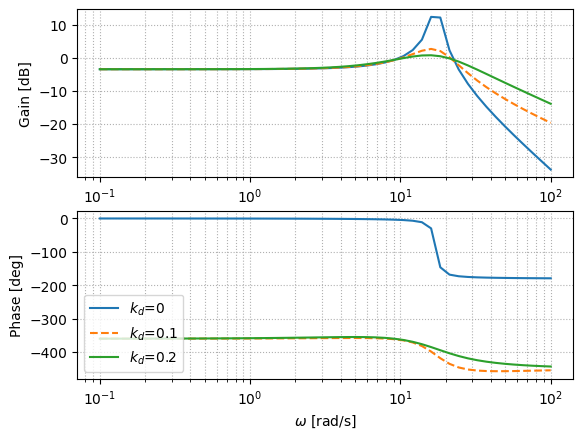

In [34]:
LS = linestyle_generator()
fig, ax = plt.subplots(2, 1)
for i in range(3):
    K = tf([kd[i], kp], [0, 1])
    Gyr = feedback(P * K, 1)
    gain, phase, w = bode(Gyr, logspace(-1, 2), plot=False)

    pltargs = {'ls':next(LS), 'label': '$k_d$=' + str(kd[i])}
    ax[0].semilogx(w, 20*np.log10(gain), **pltargs)
    ax[1].semilogx(w, phase*180/np.pi, **pltargs)
bodeplot_set(ax, 'lower left')

### PID制御を用いたときのステップ応答

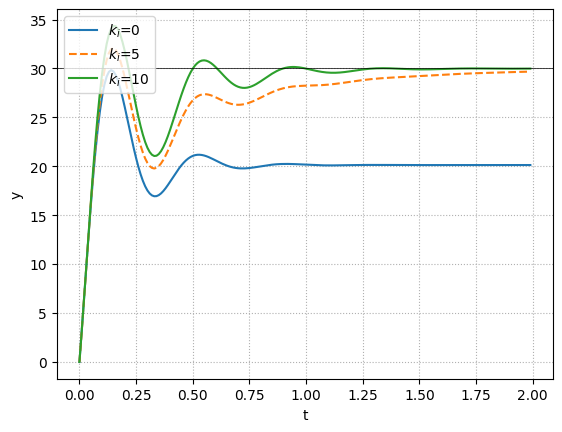

In [35]:
kp = 2
kd = 0.1
ki = (0, 5, 10)

LS = linestyle_generator()
fig, ax = plt.subplots()
for i in range(3):
    K = tf([kd, kp, ki[i]], [1, 0])     # PID Control
    Gyr = feedback(P * K, 1)            # Closed loop system
    y, t = step(Gyr, np.arange(0, 2, 0.01))

    pltargs = {'ls': next(LS), 'label': '$k_i$=' + str(ki[i])}
    ax.plot(t, y*ref, **pltargs)
ax.axhline(ref, color='k', linewidth=0.5)
plot_set(ax, 't', 'y', 'upper left') 

#### PID制御を用いたときのボード線図

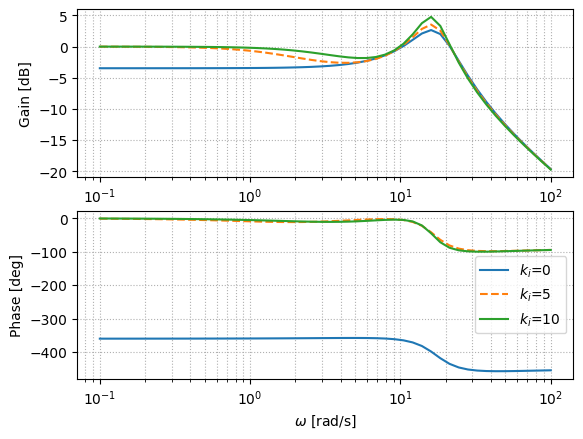

In [36]:
LS = linestyle_generator()
fig, ax = plt.subplots(2, 1)
for i in range(3):
    K = tf([kd, kp, ki[i]], [1, 0])         # PID Control
    Gyr = feedback(P * K, 1)                # Closed loop system
    gain, phase, w = bode(Gyr, logspace(-1, 2), plot=False)

    pltargs = {'ls': next(LS), 'label':'$k_i$=' + str(ki[i])}
    ax[0].semilogx(w, 20*np.log10(gain), **pltargs)
    ax[1].semilogx(w, phase*180/np.pi, **pltargs)
bodeplot_set(ax, 'best')

#### PID制御の外乱抑制性能

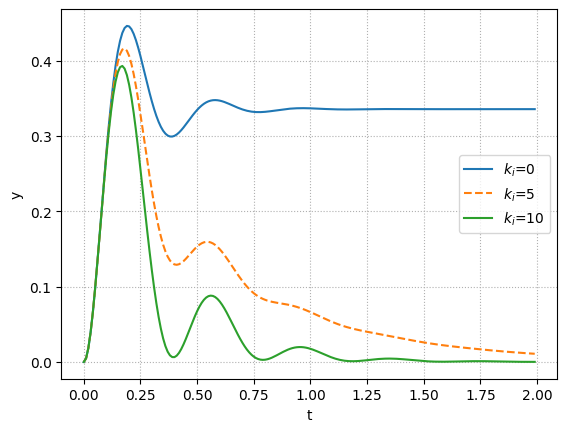

In [40]:
LS = linestyle_generator()
fig, ax = plt.subplots()
for i in range(3):
    K = tf([kd, kp, ki[i]], [1, 0])
    Gyd = feedback(P, K)
    y, t = step(Gyd, np.arange(0, 2, 0.01))

    pltargs = {'ls':next(LS), 'label': '$k_i$=' + str(ki[i])}
    ax.plot(t, y, **pltargs)

plot_set(ax, 't', 'y', 'center right')

#### PID制御の外乱抑制性能(ボード線図)

c:\Users\kaito\AppData\Local\Programs\Python\Python37\lib\site-packages\control\freqplot.py:188: FutureWarning: 'Plot' keyword is deprecated in bode_plot; use 'plot'
  FutureWarning)


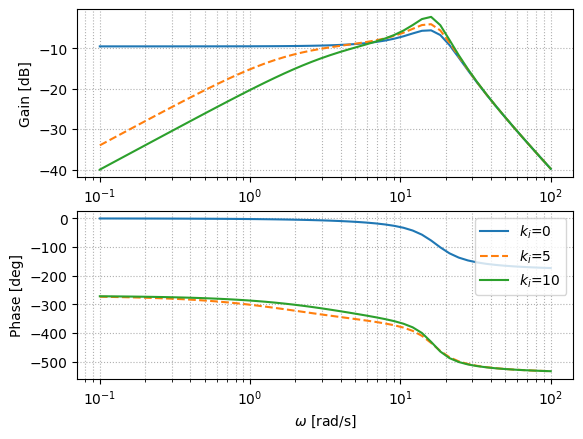

In [41]:
LS = linestyle_generator()
fig, ax = plt.subplots(2, 1)
for i in range(3):
    K = tf([kd, kp, ki[i]], [1, 0])
    Gyd = feedback(P, K)
    gain, phase, w = bode(Gyd, logspace(-1, 2), Plot=False)

    pltargs = {'ls':next(LS), 'label': '$k_i$=' + str(ki[i])}
    ax[0].semilogx(w, 20*np.log10(gain), **pltargs)
    ax[1].semilogx(w, phase*180/np.pi, **pltargs)
bodeplot_set(ax, 'best')